# Projekt 2

Klasyfikacja na wybranej bazie danych

### Jan Kieżun

---

Temat: Testowanie różnych algorytmów klasyfikujących dla numeryczno-kategorycznej bazie danych z informacjami o pacjentach z cukrzycą

---

### 1. Wstęp

Na bazie danych zostały przeprowadzone dwa eksperymenty rózniące się procesem przetworzenia danych. Na obu dokonanu testu klasyfikatorów: KNN, Naive Bayes, Decision Tree i sieć neuronowa.

Poniżej importy:

In [23]:
# numerical classification of diabetes
# with basic classification algorithms like KNN, Naive Bayes, Decision Tree and neural network
# data source: https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import LearningCurveDisplay, learning_curve

dir = '.\\'


### 2. Dane bez ekstremalnych przypadków

#### 2.1 Ładowanie i przeróbka danych

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99197 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               99197 non-null  object 
 1   age                  99197 non-null  float64
 2   hypertension         99197 non-null  int64  
 3   heart_disease        99197 non-null  int64  
 4   smoking_history      99197 non-null  object 
 5   bmi                  99197 non-null  float64
 6   HbA1c_level          99197 non-null  float64
 7   blood_glucose_level  99197 non-null  int64  
 8   diabetes             99197 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 7.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99197 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               99197 non-null  int64  
 1   age              

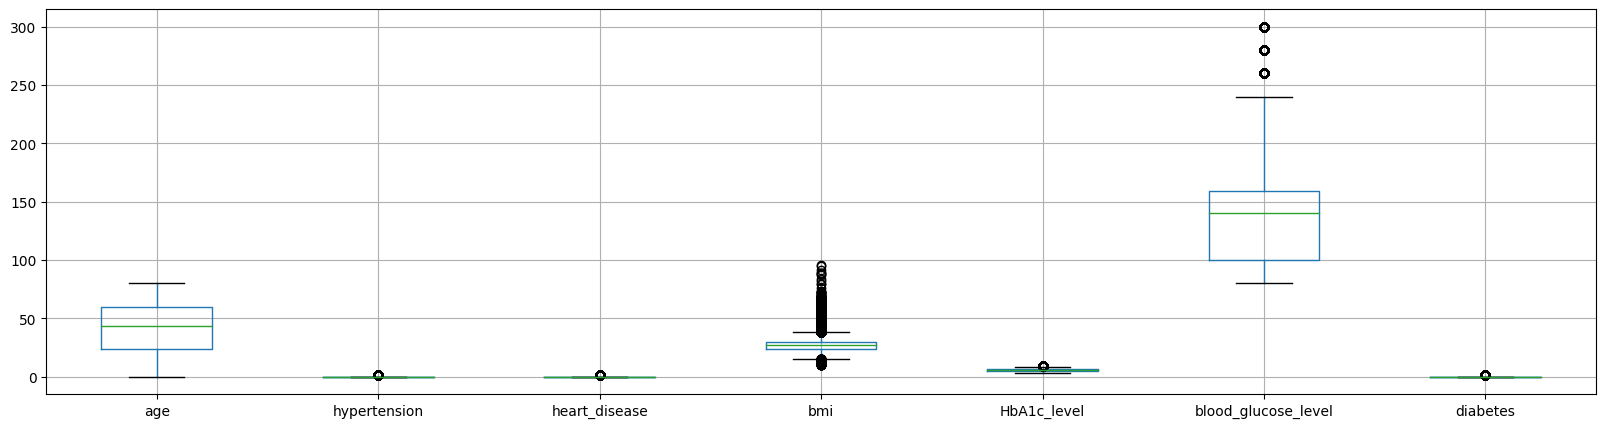

In [43]:
# load data
data = pd.read_csv(
    dir+"diabetes_prediction_dataset.csv"
)

# data preprocessing
# check for missing values
data.isnull().sum()

# check for outliers
data.boxplot(figsize=(20, 5))

# remove outliers
data = data[data["bmi"] < 60]
data = data[data["blood_glucose_level"] < 300]
data = data[data["blood_glucose_level"] > 50]
data = data[data["gender"] != "Other"]
data.info()

# replace smoking_history with numerical values
smoking_history_template = {
    "never": 0,
    "former": 1,
    "not current": 2,
    "current": 3,
    "ever": 4,
    "No Info": 5,
}

data["smoking_history"] = data["smoking_history"].map(smoking_history_template)


gender_template = {
    "Female": 0,
    "Male": 1,
}
data["gender"] = data["gender"].map(gender_template)

data.info()


#### 2.2 Przygotowanie zbiorów treningów i testowych, a następnie standaryzacja danych.

In [44]:
# split data into training and test sets
X = data.drop(["diabetes"], axis=1)
y = data["diabetes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=278882)
# scale data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### 2.3 Klasyfikatory:

##### 2.3.1 KNN, szukanie najbardziej optymalnej liczby sąsiadów

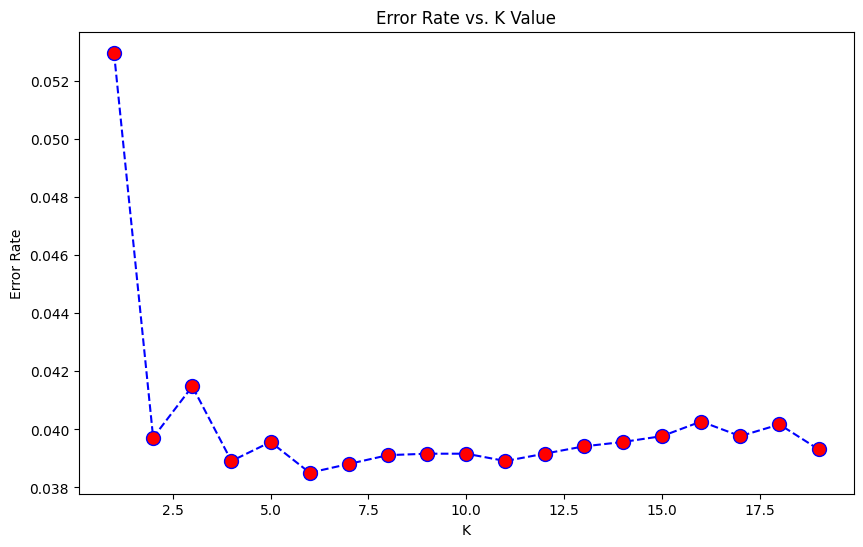

In [26]:
def knn_plot():
    error_rate = []
    for i in range(1, 20):
        knn = KNeighborsClassifier(n_neighbors=i, metric="euclidean")
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        error_rate.append(np.mean(y_pred != y_test))
        

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 20), error_rate, color="blue", linestyle="dashed", marker="o", markerfacecolor="red", markersize=10, label="error rate")
    plt.title("Error Rate vs. K Value")
    plt.xlabel("K")
    plt.ylabel("Error Rate")
    plt.show()
knn_plot()

Test liczby sąsiadów z najmniejszym błędem.

0.961491935483871
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18236
           1       0.94      0.56      0.70      1604

    accuracy                           0.96     19840
   macro avg       0.95      0.78      0.84     19840
weighted avg       0.96      0.96      0.96     19840



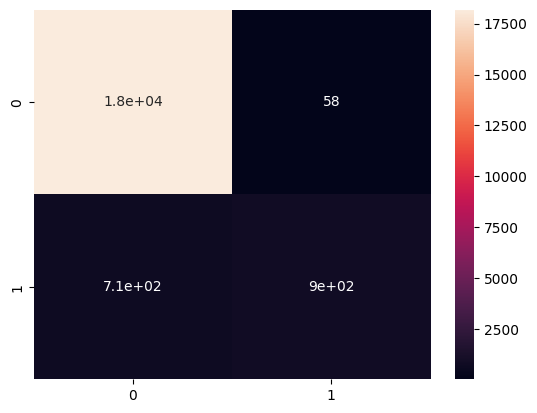

In [46]:
knn = KNeighborsClassifier(n_neighbors=6, metric="euclidean")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# evaluate model
cm = confusion_matrix(y_test, y_pred)
# plot confusion matrix
sns.heatmap(cm, annot=True)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Obserwacja

KNN znalazł bardzo dobry accuracy, ale nie odzwierciedla się to na osobach z cukrzycą bo ich accuracy wynosi tylko 56%

##### 2.3.2 Naive Bayes, sprawdzanie wartości ogólnej accuracy i accuracy poprawnie zgadniętych osób z cukrzycą w zależności on parametru priors.

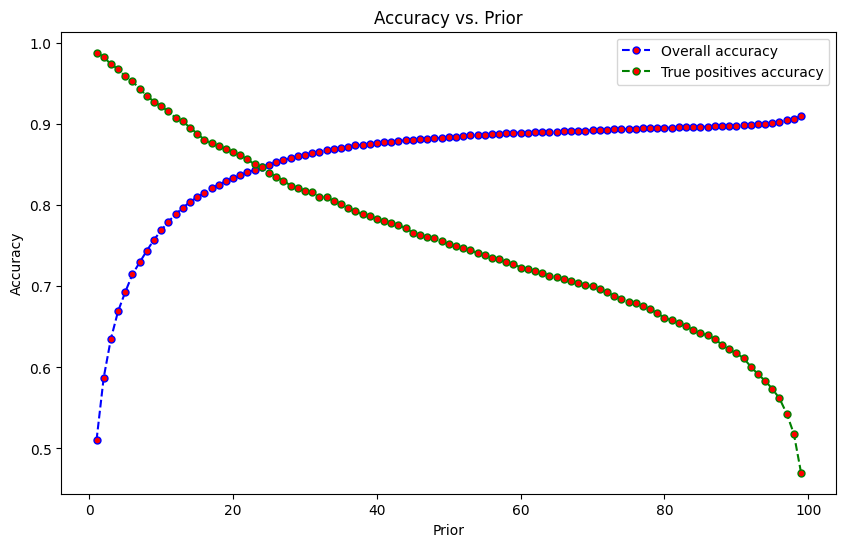

In [28]:
# Naive Bayes check for optimal priors for overall accuracy with more importance on true positives
def naive_bayes_plot():
    accuracy = []
    true_positives_accuracy = []
    for i in range(1, 100):
        nb = GaussianNB(priors=[i/100, 1-i/100])
        nb.fit(X_train, y_train)
        y_pred = nb.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        true_positives_accuracy.append(cm[1][1]/(cm[1][1]+cm[1][0]))

    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 100), accuracy, color="blue", linestyle="dashed", marker=".", markerfacecolor="red", markersize=10, label="Overall accuracy")
    plt.plot(range(1, 100), true_positives_accuracy, color="green", linestyle="dashed", marker=".", markerfacecolor="red", markersize=10, label="True positives accuracy")
    plt.title("Accuracy vs. Prior")
    plt.xlabel("Prior")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
naive_bayes_plot()


Test Naive Bayes dla wartości priors ustawionych na bazie wcześniejszego wykresu, czyli gdy accuracy ogólna i accuracy poprawnie odganiętych osób z cukrzycą jest mniej więcej takie same.

0.8370967741935483
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     18236
           1       0.31      0.86      0.46      1604

    accuracy                           0.84     19840
   macro avg       0.65      0.85      0.68     19840
weighted avg       0.93      0.84      0.87     19840



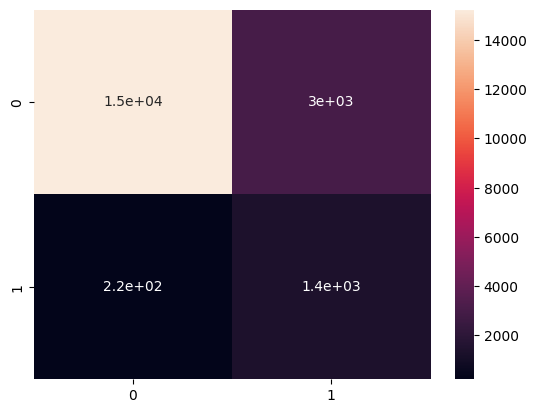

In [29]:
nb = GaussianNB(priors=[0.21, 0.79])
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# evaluate model
cm = confusion_matrix(y_test, y_pred)
# plot confusion matrix
sns.heatmap(cm, annot=True)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Obserwacja

Do danych ciężko ustawić parametry, które spowodują że klasyfikacja będzie dokładna dla wszystkich przypadków. Tutaj została położona większa waga na poprawnie odgadniętych cukrzyków, przez co ogólna dokładność spadła.

##### 2.3.3 Drzewo decyzyjne

0.9526713709677419
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     18236
           1       0.71      0.71      0.71      1604

    accuracy                           0.95     19840
   macro avg       0.84      0.84      0.84     19840
weighted avg       0.95      0.95      0.95     19840



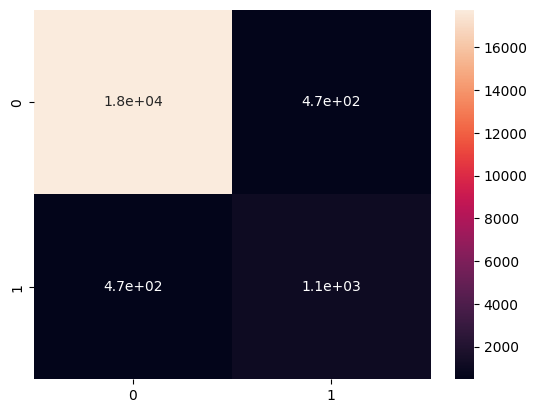

In [30]:
# Decision Tree of max depth 100 with entropy criterion
dt = DecisionTreeClassifier(max_depth=100, criterion="entropy")
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

# evaluate model
cm = confusion_matrix(y_test, y_pred)
# plot confusion matrix
sns.heatmap(cm, annot=True)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Obserwacje

Drzewo decyzyjne sprawuje się w porządku na tle innych klasyfikatorów, jednakże dalej daje niezadowalającą dokładność dla osób chorych na cukrzyce.

##### 2.3.4 Sieć neuronowa, rysowanie krzywej uczenia

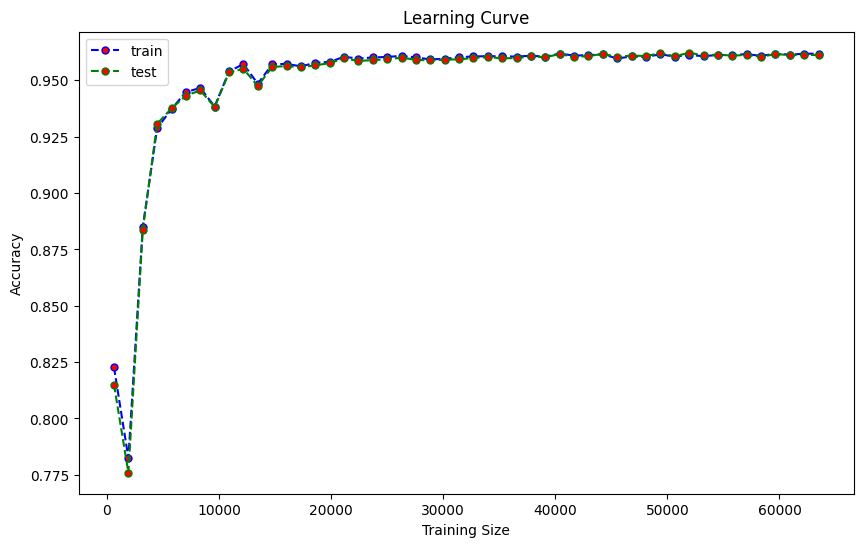

In [31]:
# Neural Network with 2 hidden layers of 10 neurons each, show learning curve that shows accuracy on training and test sets for each epoch
def nn_plot():
    train_sizes, train_scores, test_scores = learning_curve(MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=10, early_stopping = True), X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, color="blue", linestyle="dashed", marker=".", markerfacecolor="red", markersize=10, label="train")
    plt.plot(train_sizes, test_scores_mean, color="green", linestyle="dashed", marker=".", markerfacecolor="red", markersize=10, label="test")
    plt.title("Learning Curve")
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
nn_plot()

C:\Users\janki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9606350806451613
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18236
           1       0.88      0.59      0.71      1604

    accuracy                           0.96     19840
   macro avg       0.92      0.79      0.84     19840
weighted avg       0.96      0.96      0.96     19840



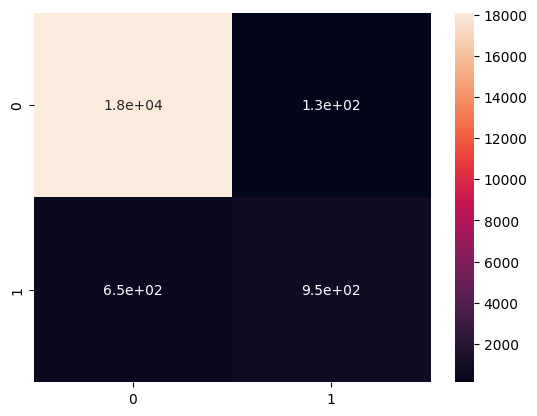

In [45]:
# neural network with 2 hidden layers of 10 neurons each
nn = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=10, early_stopping = True)
nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)

# evaluate model
cm = confusion_matrix(y_test, y_pred)
# plot confusion matrix
sns.heatmap(cm, annot=True)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Obserwacje

Sieci neuronowe również nie znajdują poprawnie cukrzyków. Krzywa nauczania dla danych treningowych i walidacyjnych jest bardzo podobna, więc te zależności między tymi danymi są bardzo podobne.

### 3. Dane mniej obrobione

Wyniki są bardzo podobne do tych z punktu 2 i nic nowego nie wnoszą.

In [32]:
# data with less preprocessing
data = pd.read_csv(dir+"diabetes_prediction_dataset.csv")
# data.info()

# replace smoking_history with numerical values
smoking_history_template = {
    "never": 0,
    "former": 1,
    "not current": 2,
    "current": 3,
    "ever": 4,
    "No Info": 5,
}

data["smoking_history"] = data["smoking_history"].map(smoking_history_template)

# gender to numerical values
gender_template = {
    "Female": 0,
    "Male": 1,
    "Other": 2,
}

data["gender"] = data["gender"].map(gender_template)

data.info()

# split data into training and test sets
X = data.drop(["diabetes"], axis=1)
y = data["diabetes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=278882)

# scale data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  int64  
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  int64  
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 6.9 MB


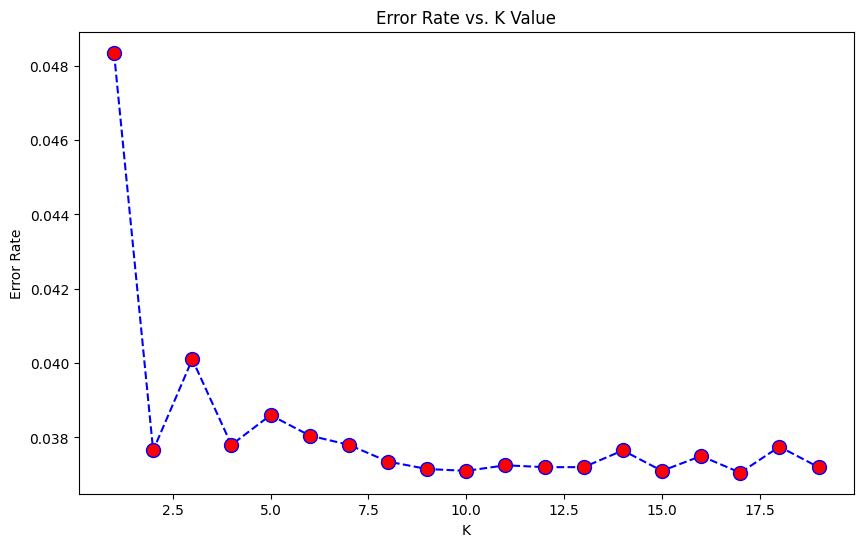

In [33]:
# KNN with n neighbors and euclidean distance metric as a baseline model, find optimal n in range 1-20
def knn_plot():
    error_rate = []
    for i in range(1, 20):
        knn = KNeighborsClassifier(n_neighbors=i, metric="euclidean")
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        error_rate.append(np.mean(y_pred != y_test))
        

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 20), error_rate, color="blue", linestyle="dashed", marker="o", markerfacecolor="red", markersize=10, label="error rate")
    plt.title("Error Rate vs. K Value")
    plt.xlabel("K")
    plt.ylabel("Error Rate")
    plt.show()
knn_plot()

0.96285
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18294
           1       0.93      0.61      0.74      1706

    accuracy                           0.96     20000
   macro avg       0.95      0.80      0.86     20000
weighted avg       0.96      0.96      0.96     20000



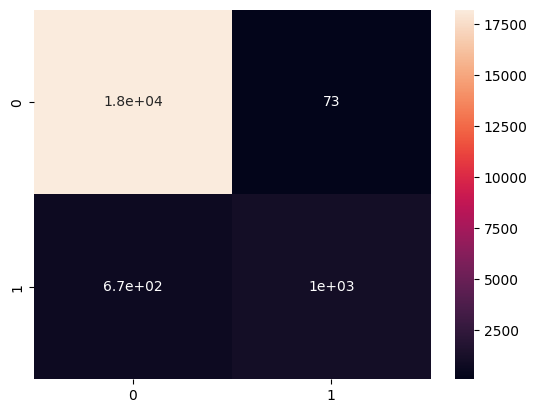

In [34]:
# KNN with n=9
knn = KNeighborsClassifier(n_neighbors=9, metric="euclidean")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# evaluate model
cm = confusion_matrix(y_test, y_pred)
# plot confusion matrix
sns.heatmap(cm, annot=True)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

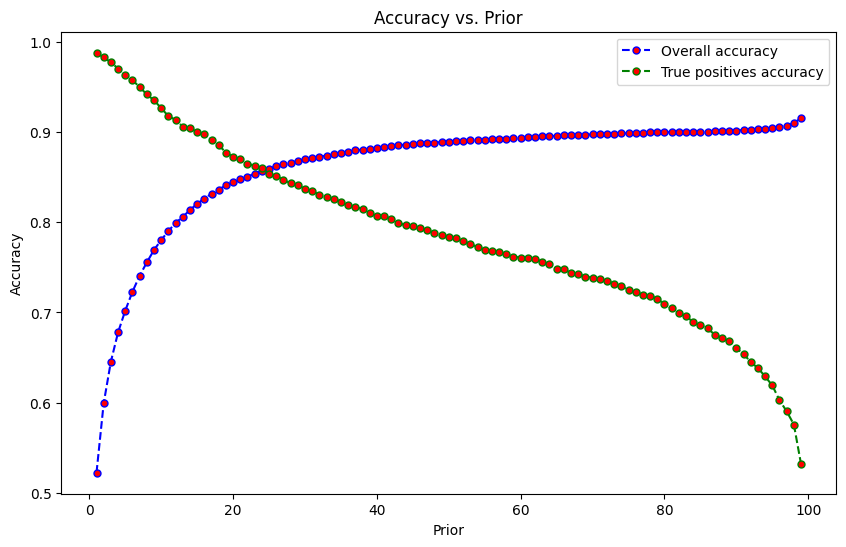

In [35]:
# Naive Bayes check for optimal priors for overall accuracy with more importance on true positives
def naive_bayes_plot():
    accuracy = []
    true_positives_accuracy = []
    for i in range(1, 100):
        nb = GaussianNB(priors=[i/100, 1-i/100])
        nb.fit(X_train, y_train)
        y_pred = nb.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        true_positives_accuracy.append(cm[1][1]/(cm[1][1]+cm[1][0]))

    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 100), accuracy, color="blue", linestyle="dashed", marker=".", markerfacecolor="red", markersize=10, label="Overall accuracy")
    plt.plot(range(1, 100), true_positives_accuracy, color="green", linestyle="dashed", marker=".", markerfacecolor="red", markersize=10, label="True positives accuracy")
    plt.title("Accuracy vs. Prior")
    plt.xlabel("Prior")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
naive_bayes_plot()

0.84775
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     18294
           1       0.34      0.87      0.49      1706

    accuracy                           0.85     20000
   macro avg       0.67      0.86      0.70     20000
weighted avg       0.93      0.85      0.87     20000



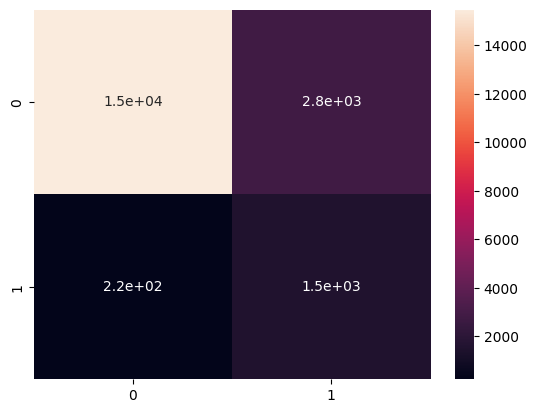

In [36]:
# Naive Bayes with prior of 0.21 and 0.79
nb = GaussianNB(priors=[0.21, 0.79])
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# evaluate model
cm = confusion_matrix(y_test, y_pred)
# plot confusion matrix
sns.heatmap(cm, annot=True)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9513
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     18294
           1       0.70      0.75      0.72      1706

    accuracy                           0.95     20000
   macro avg       0.84      0.86      0.85     20000
weighted avg       0.95      0.95      0.95     20000



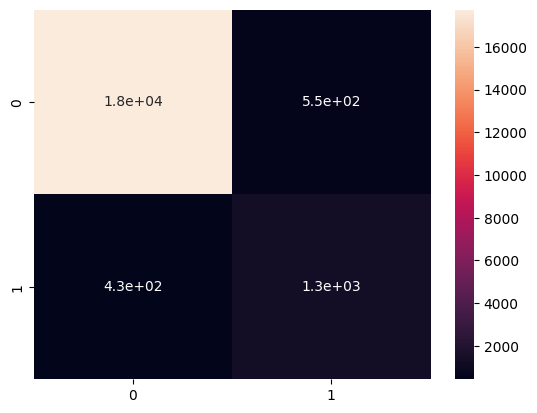

In [40]:
# Decision Tree of max depth 10 then visualize it in a png file
# true positives are more important than true negatives
dt = DecisionTreeClassifier(max_depth=100, criterion="entropy")
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

# evaluate model
cm = confusion_matrix(y_test, y_pred)
# plot confusion matrix
sns.heatmap(cm, annot=True)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# plot decision tree
# from sklearn import tree

# fig = plt.figure(figsize=(25, 20))
# _ = tree.plot_tree(dt, feature_names=X.columns, class_names=["0", "1"], filled=True)
# fig.savefig(dir+"decision_tree.png")

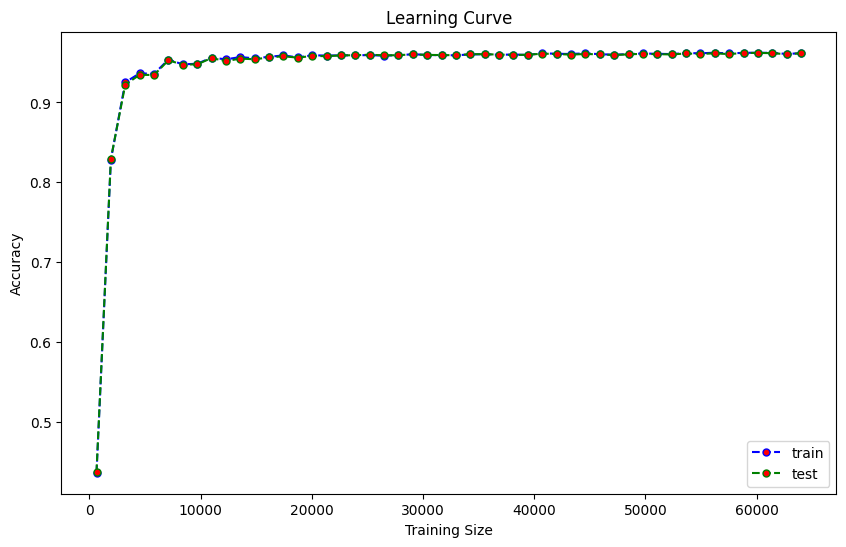

In [38]:
# Neural Network with 2 hidden layers of 10 neurons each, plot learning curve
def nn_plot():
    train_sizes, train_scores, test_scores = learning_curve(MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=10, early_stopping = True), X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, color="blue", linestyle="dashed", marker=".", markerfacecolor="red", markersize=10, label="train")
    plt.plot(train_sizes, test_scores_mean, color="green", linestyle="dashed", marker=".", markerfacecolor="red", markersize=10, label="test")
    plt.title("Learning Curve")
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
nn_plot()

0.96165
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18294
           1       0.88      0.64      0.74      1706

    accuracy                           0.96     20000
   macro avg       0.92      0.82      0.86     20000
weighted avg       0.96      0.96      0.96     20000



C:\Users\janki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


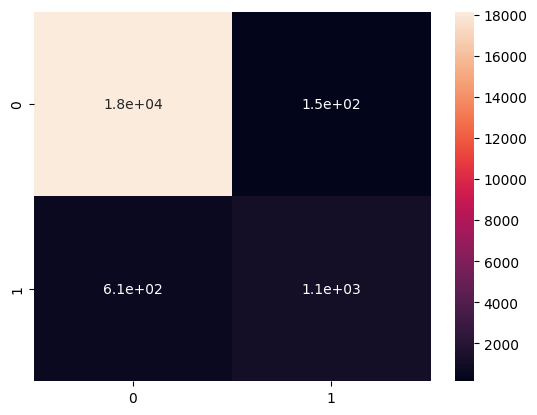

In [42]:
# Neural Network with 2 hidden layers of 10 neurons each
nn = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=10, early_stopping = True)
nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)

# evaluate model
cm = confusion_matrix(y_test, y_pred)
# plot confusion matrix
sns.heatmap(cm, annot=True)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

### 4. Wnioski

Dane mają większość osób zdrowych (ok. 90%), dlatego klasyfikacja Naive Bayes, w której można zmienić parametr priors najlepiej znajduje cukrzyków. Nie było znaczących różnic między danymi bez brzegowych osób od tych z osobami, które mają np. bmi>60 lub płeć "other". Dane nie miały pól pustych.